### __**Dynamics of LIF Recurrent Neural Network with Homeostatic Regulations**__ ###
#### *BIOE-610 Recurrent Neural Networks Final Project, Winter 2024*  
*Aiden Dillon* 


This notebook features a toy model of the nueral network from Kossio et al, 2018. The network is comprised of leaky integrate and fire (LIF) neurons, whom are connected via spatial overlap of dendrite arbor radius. 

In this model, integrate and fire neurons operate by continuously accumulating charge (membrane potential), coming from continuous input noise and spiking from presynaptic neurons. Once the membrane potential of a neuron has reached a certain threshold, $V_{thresh}$, the neuron fires, or spikes, sending a signal in the form of current to it's postysynaptic connections. After spiking, the neuron's membrane potential is depleted, leaving it at a baseline potential, $V_{rest}$. LIF neurons include a leak term, indicating continuous decay of mebrane potential over time, mimicing physical neurons. In this model, the input noise and leaking were modeled as continuous, with the input from presynaptic neurons instantaneously transferring potential to its postsynaptic connections. The membrane potential dynamics are described by the expressions below, 

$\newline$  
$\text{J} = \text{g}\text{M} \cdot \text{S}$
$\newline$  
$\frac{dV}{dt} = I - L$
$\newline$  
$V(t + \Delta t) = V(t) + J + (\frac{dV}{dt} \times \Delta t)$ 

where:

- g is the synpatic weight, i.e. how much of a neuron's spike signal is transmitted to its postsynaptic connection
- M is the connectivity matrix, desrbing the connection strength between two neurons at indicies i, j. There are no self connections, and M is constructed to be antisymmetric, mimicing one-way connections in biological neural networks.
- S is a binary state vector, descrbing which neurons at a specific time are in the spiking state
- I is the input noise, i.e. noise current coming from external network stimulation
- L is the leaked current, proportional to how close a neuron'es membrane potential is to $V_{threshold}$
- $\Delta t$ is the time step of the simulation  

This model adapts a plasticity method based on the growth of the dendrite arbor radius, whose dynamics are governed by comparison to an assumed homeostatic target firing rate, $f_{target}$. If the firing rate of an individual neuron falls below $f_{target}$, the dendrite arbor (modeled as a circle) radius will increase in an attempt to connect to other neurons in its vicinity, and vice-versa. Connection strengths, i.e. the elements comprising matrix M, are wholy dependent on the spatial overlap of these arbor radii between neurons, with connection strength being proportional to the overlap area between the two arbor radii, normalized from 0 to 1--as arbor radius overlap increases, the availability for synaptic connections does as well. Kossio uses an inhomogenous Poisson-point model for their neurons, where spiking is a stochastic process, allowing them to describe an instantaneous firing rate. In this model, due to the construction of network dynamics and computational resources, the firing rate of an individual neuron is a continuously updating function of  $f = \frac{N_{spikes}}{time}$, where time increases linearly as the network dynamics evolve.   

For all proceeding simulations, $V_{thresh}$ = 1 and $V_{rest}$ = -1 for simplicity. Neurons with randomly distributed initial sizes are randomly deposited within a scalable sandbox.


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import math
from tqdm import tqdm
from scipy.stats import powerlaw

In [4]:
class Neuron:
    def __init__(self, potential, position, size, color='black', reset_potential=-1):
        self.position = position
        self.size = size
        self.color = color
        self.reset_potential = reset_potential
        self.potential = potential
        self.spiking = np.random.rand() > 0.5
        self.firing_rate = int(self.spiking) 
        self.nspikes = int(self.spiking)
        if self.spiking: self.potential = reset_potential
        
    def determine_neuron_color(self):
            if self.spiking: 
                color = 'green' 
                self.nspikes += 1
            else: 
                voltage_normalized = (self.potential + 1) / 2
                color_rgb = plt.cm.winter(voltage_normalized)[:3]
                color = color_rgb
            return color
        
        

In [128]:
class Network:
    def __init__(self, N=60, tfr = 0.01, sandbox_size=(1000, 1000), size_range=(5, 50)):
        
        self.N = N
        self.sandbox_size = sandbox_size
        self.size_range = size_range
        self.neurons = self.init_neurons()
        
        self.M = self.init_connectivity_matrix()
        self.triu = np.triu_indices_from(self.M, k=1)
        self.trili = np.tril_indices_from(self.M, k=-1)
        self.update_connectivity_matrix()# evolving connectivity matrix M
        
        self.tfr = tfr # target firing rate
        self.growth_coeff = 0.01
        self.t = 0
      

    def init_connectivity_matrix(self):
        M = np.random.rand(self.N, self.N)
        M = M - np.transpose(M)
        np.fill_diagonal(M, 0)
        M = M / np.sum(abs(M))
        return M


    def init_neurons(self):
        sandbox_width, sandbox_height = self.sandbox_size
        neurons = []
        for _ in range(self.N):
            potential = 2*np.random.rand()-1
            position = tuple(np.random.rand(2) * [sandbox_width, sandbox_height])
            size = np.random.uniform(self.size_range[0], self.size_range[1])
            color = 'black'
            neurons.append(Neuron(potential, position, size, color))
        return neurons
          
            
    def check_overlap(self, neuron1, neuron2):
        distance_squared = (neuron1.position[0] - neuron2.position[0])**2 + (neuron1.position[1] - neuron2.position[1])**2
        return (neuron1.size + neuron2.size)**2 > distance_squared


    def circle_overlap_area(self, neuron1, neuron2):
        x1, y1, r1 = neuron1.position[0], neuron1.position[1], neuron1.size
        x2, y2, r2 = neuron2.position[0], neuron2.position[1], neuron2.size
        d = ((x2 - x1)**2 + (y2 - y1)**2)
        
        if d <= (r1 - r2)**2 and r1 >= r2:
            return math.pi * r2**2
        
        elif d <= (r1 - r2)**2 and r1 < r2:
            return math.pi * r1**2
        
        else:
            d = math.sqrt(d)
            h = (1/(2*d))*math.sqrt(2*(d**2)*(r1**2)+2*(d**2)*(r2**2) + 2*(r1**2)*(r2**2)-d**4 - r1**4 - r2**4)
            
            return (r1**2)*math.asin(h/r1)+(r2**2)*math.asin(h/r2) - d*h
        
    def update_connectivity_matrix(self):
        
        for k in range(len(self.triu[0])):
            i = self.triu[0][k]
            j = self.triu[1][k]
            
            if self.check_overlap(self.neurons[i], self.neurons[j]):
                overlap_area = self.circle_overlap_area(self.neurons[i], self.neurons[j])
                self.M[i][j] = overlap_area/(math.pi*(self.size_range[1])**2)
            else: 
                self.M[i][j] = 0
                      
        self.M[self.trili] = -self.M[self.triu]


    def simulate(self, duration = 2, dt = 0.1, spike_input=0.5, input_noise = 0.1, leak=0.01, spike_threshold = 1, REST=-1, animate=True):
        
        # initializing global lists
        
        spikes_list = []
        V_list = []
        firing_rates_list = []
        size_list = []
        
        # initializing V and spike state vectors
        
        V = np.array([neuron.potential for neuron in self.neurons])
        spikes = [neuron.spiking for neuron in self.neurons]
        
        iterations = int(duration/dt) 
        
        if animate:
            fig, ax = plt.subplots()
            frames = []
        
            for _ in tqdm(range(iterations), desc="Simulating"):
                
                self.t += dt
                
                # Updating V (potential). Spike inputs are translated immediately
                
                spike_input_contribution = spike_input * np.dot(self.M, spikes)
                dV_dt = input_noise * np.random.rand(self.N) - leak * (V - REST)
                V += spike_input_contribution + (dV_dt * dt)
                
                # Checking which neurons spike, then resetting potentials
                
                spikes = (V >= spike_threshold)
                V[spikes] = REST
                V[V < REST] = REST

                # Updating neuron object attributes for neurons in network
                
                for i, neuron in enumerate(self.neurons):
                    neuron.spiking = spikes[i]
                    neuron.potential = V[i]
                    neuron.color = neuron.determine_neuron_color()
                    neuron.spiking = False
                    neuron.firing_rate = neuron.nspikes / self.t
                                    
                    if neuron.firing_rate < self.tfr:
                        neuron.size *= (1 + self.growth_coeff)
                    elif neuron.firing_rate >= self.tfr: 
                        neuron.size *= (1 - self.growth_coeff)
                    if neuron.size > self.size_range[1]: neuron.size = self.size_range[1]
                    if neuron.size < self.size_range[0]: neuron.size = self.size_range[0]
                
                # Updating global lists (keep track of all attributes for every iteration)
                
                self.update_connectivity_matrix()
                firing_rates = [neuron.firing_rate for neuron in self.neurons]
                neuron_sizes = [neuron.size for neuron in self.neurons]
                mean_firing_rate = np.mean(np.array(firing_rates))
                
                V_list.append(V.copy())
                spikes_list.append(spikes.copy())
                firing_rates_list.append(firing_rates.copy())
                size_list.append(neuron_sizes.copy())                
                
                ax.clear()
                for neuron in self.neurons:
                    circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
                    ax.add_artist(circle)
                ax.set_xlim(0, self.sandbox_size[0])
                ax.set_ylim(0, self.sandbox_size[1])
                ax.set_aspect('equal')
                ax.axis('off')
                buf = io.BytesIO()
                fig.savefig(buf, format='png')
                buf.seek(0)
                frames.append(imageio.imread(buf))

            imageio.mimsave('area_plasticity.gif', frames, duration=0.1)
            print('mean firing rate:', mean_firing_rate)    
            return spikes_list, V_list, firing_rates_list, size_list
        
        else:
            
            for _ in tqdm(range(iterations), desc="Simulating"):
                
                self.t += dt
                
                # Updating V (potential). Spike inputs are translated immediately
                
                spike_input_contribution = spike_input * np.dot(self.M, spikes)
                dV_dt = input_noise * np.random.rand(self.N) - leak * (V - REST)
                V += spike_input_contribution + (dV_dt * dt)
                
                # Checking which neurons spike, then resetting potentials
                
                spikes = (V >= spike_threshold)
                V[spikes] = REST
                V[V < REST] = REST

                # Updating neuron object attributes for neurons in network
                
                for i, neuron in enumerate(self.neurons):
                    neuron.spiking = spikes[i]
                    if neuron.spiking: neuron.nspikes += 1
                    neuron.firing_rate = neuron.nspikes / self.t
                    
                    neuron.potential = V[i]
                                    
                    if neuron.firing_rate < self.tfr:
                        neuron.size *= (1 + self.growth_coeff)
                    elif neuron.firing_rate >= self.tfr: 
                        neuron.size *= (1 - self.growth_coeff)
                    if neuron.size > self.size_range[1]: neuron.size = self.size_range[1]
                    if neuron.size < self.size_range[0]: neuron.size = self.size_range[0]
                

                self.update_connectivity_matrix()
                
                # Updating global lists (keep track of all attributes for every iteration)
                
                firing_rates = [neuron.firing_rate for neuron in self.neurons]
                neuron_sizes = [neuron.size for neuron in self.neurons]
                mean_firing_rate = np.mean(np.array(firing_rates))
                    
                V_list.append(V.copy())
                spikes_list.append(spikes.copy())
                firing_rates_list.append(firing_rates.copy())
                size_list.append(neuron_sizes.copy())                         
            
        print('mean firing rate:', mean_firing_rate)    
        return spikes_list, V_list, firing_rates_list, size_list
        
        
    def compute_avalanche_sizes(self, spikes_list, avalanche_threshold, tau_seconds):

        num_steps = len(spikes_list)

        tau_steps = int(tau_seconds / 0.01)

        avalanche_sizes = []
        current_avalanche_size = 0

        for t in range(num_steps):

            window_start = max(0, t - tau_steps)
            window_end = min(num_steps, t + 1)

            n_neurons_spiking = np.sum(spikes_list[window_start:window_end])

            if n_neurons_spiking >= avalanche_threshold:
                current_avalanche_size += 1
                
            else:

                if current_avalanche_size > 0:
                    avalanche_sizes.append(current_avalanche_size)
                    current_avalanche_size = 0

        return avalanche_sizes

In [95]:
class Graphics:
    
    def draw(self, network):
        fig, ax = plt.subplots(figsize=(10, 10))
        for neuron in network.neurons:
            circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
            ax.add_artist(circle)
        ax.set_xlim(0, network.sandbox_size[0])
        ax.set_ylim(0, network.sandbox_size[1])
        ax.set_aspect('equal')
        ax.axis('off')

    def plot_neuron_activity(self, spikes_list, V_list):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(1-np.array(spikes_list).T, aspect='auto')
        plt.xlabel('Time')
        plt.ylabel('Neuron Index')
        plt.title('Neuron Firings Over Time')
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(V_list).T, aspect='auto', cmap='winter')
        plt.xlabel('Time')
        plt.ylabel('Neuron index')
        plt.title('Membrane Potential Over Time')
        plt.colorbar(label='Membrane Potential')
        plt.tight_layout()
        plt.show()
        
    def plot_M(self, network):
        plt.figure()
        plt.imshow(network.M)
        colorbar = plt.colorbar()
        colorbar.set_label('Synaptic Connection Strength')
        plt.xlabel('Neuron index')
        plt.ylabel('Neuron index')
        plt.title('Connectivity Matrix M')

    def plot_firing_rates(self, network, firing_rates_list):
        plt.figure()
        fr_img = plt.imshow(np.array(firing_rates_list).T, aspect='auto')
        plt.colorbar(fr_img)
        fr_img.set_clim(0, 1.5 * network.tfr)
        plt.title(f'Neuron firing rates, tfr = {network.tfr}')
        plt.xlabel('Iteration #')
        plt.ylabel('Neuron index')
        
    def plot_neuron_sizes(self, network, size_list):
        plt.figure()
        sz_img = plt.imshow(np.array(size_list).T, aspect='auto')
        plt.colorbar(sz_img)
        sz_img.set_clim(0, network.size_range[1])
        plt.title(f'Neuron radii, size range: {network.size_range}')
        plt.xlabel('Iteration #')
        plt.ylabel('Neuron index')
        
    def bin_avalance_durations(self, avalanche_sizes):
        plt.hist(avalanche_sizes, bins=range(1, max(avalanche_sizes) + 1), align='left', edgecolor='black')
        plt.xlabel('Avalanche Size')
        plt.ylabel('Frequency')
        plt.title('Histogram of Avalanche Sizes')
        plt.show()
            

Simulating:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulating: 100%|██████████| 10000/10000 [02:17<00:00, 72.91it/s]


mean firing rate: 0.15318999999997568


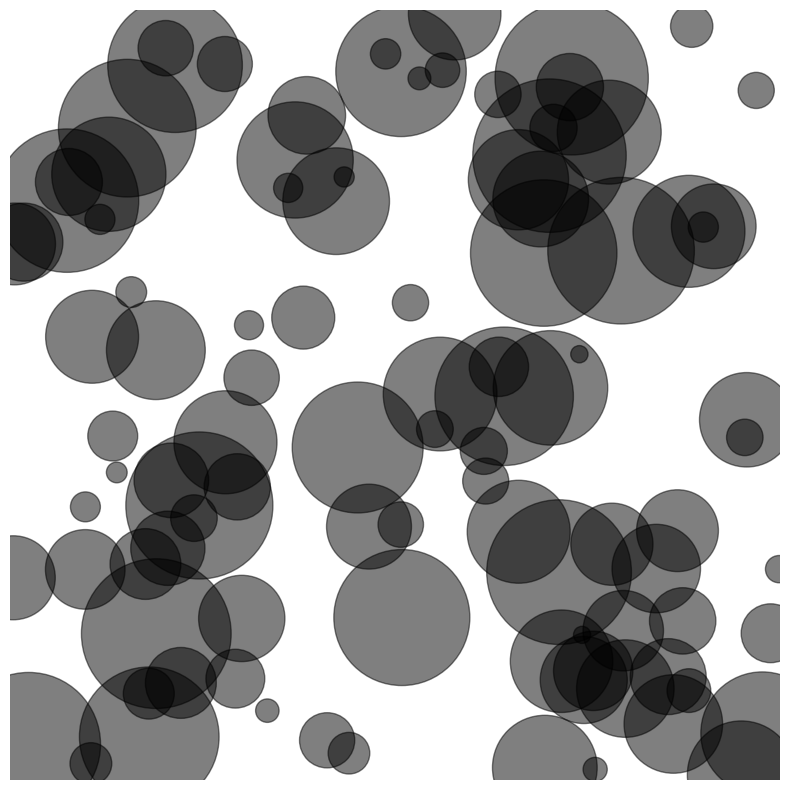

In [102]:
network = Network(N=100, sandbox_size = (1000,1000), tfr = 0.01, size_range=(10,100))
graphics = Graphics()

network.init_neurons()
graphics.draw(network)

network.tfr = 1
spikes_list, V_list, firing_rates_list, size_list = network.simulate(duration = 1000, dt = 0.1, spike_input=10, input_noise=0.5, leak=0.01, animate=False)


Firstly, let's look at the new network morphology after evolution:

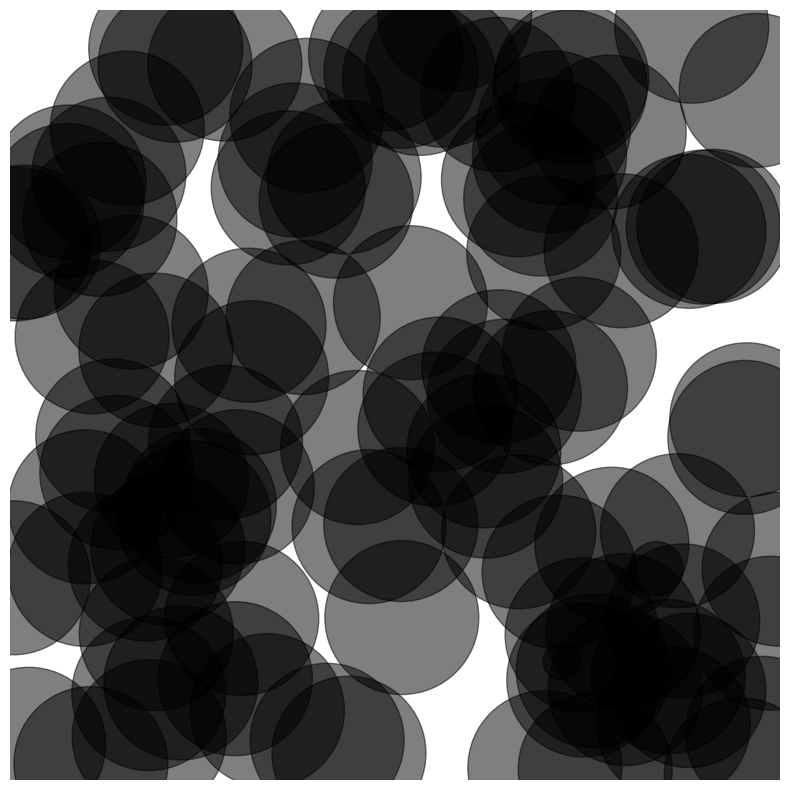

In [103]:
graphics.draw(network)

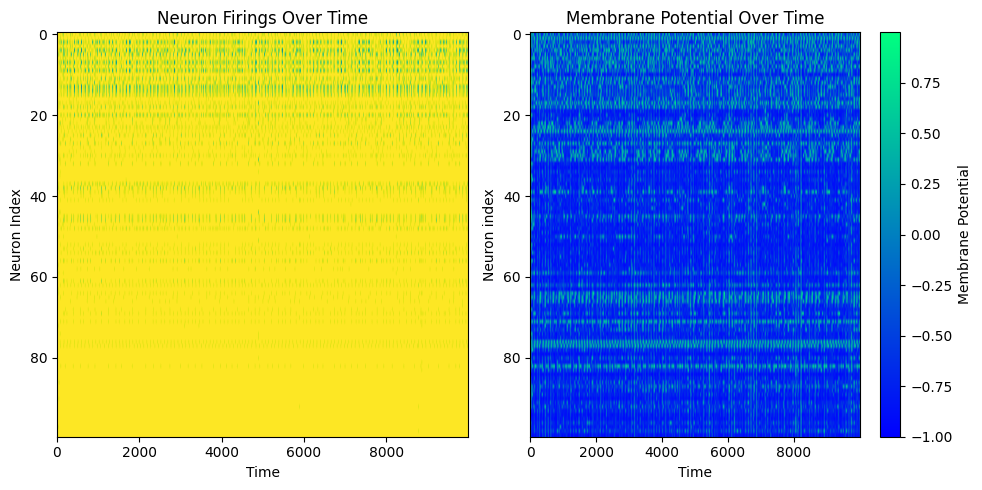

In [104]:
graphics.plot_neuron_activity(spikes_list, V_list)

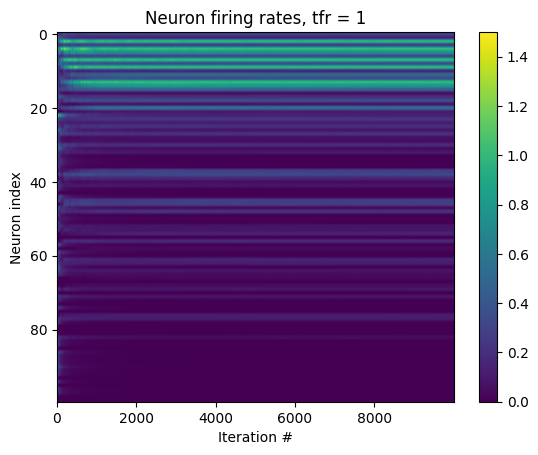

In [105]:
graphics.plot_firing_rates(network, firing_rates_list)

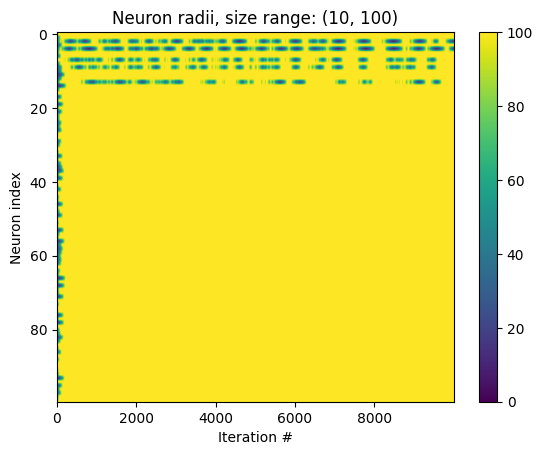

In [106]:
graphics.plot_neuron_sizes(network, size_list)

The main aim of this project was exploratory, investigating the varying network dynamics as we move around paramater space. The main focus was on the subset where g dominates I, or where a neuron's membrane potential is dominated the strength and/or number of connections. A higher input noise, increases firing rate artificially, but some is needed in order to help the network dynamics progress. Overall, the typical relationship holds where $\frac{g}{I}$~10. Leak current was regularly kept low, where $\frac{g}{L}$ ~ 100. With greater computational resources, (a recurring theme in this project) the parameter space where g and L have a more dominant effect could be explored.

Given this exploration in paramter space, I aimed to try and find a region where we can see SOC from the model. A key indicator that a network has reached a critically tuned state is the emergence of scale-free dynamics, where network behaviors are consistent through varying orders of magnitude.

A prominent measure of critical behavior in neural networks is the distribution of avalanche sizes, where avalanches are defined as periods of continuous firing within the network (above some threshold). For critical dynamics, we expect a power-law relation between avalanche size and probability density. In the plots below we can see an example of this analysis for a run of my simulation, with parameters: 

- N = 100 neurons 
- duration = 1000s  
- dt = 0.01 $\rightarrow$ 100,000 iterations
- spike_input=1 
- input_noise=0.1 
- leak=0.005
- target firing rate 0.05 Hz

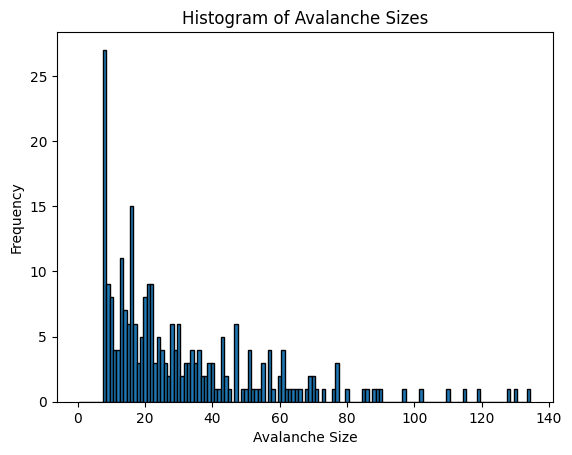

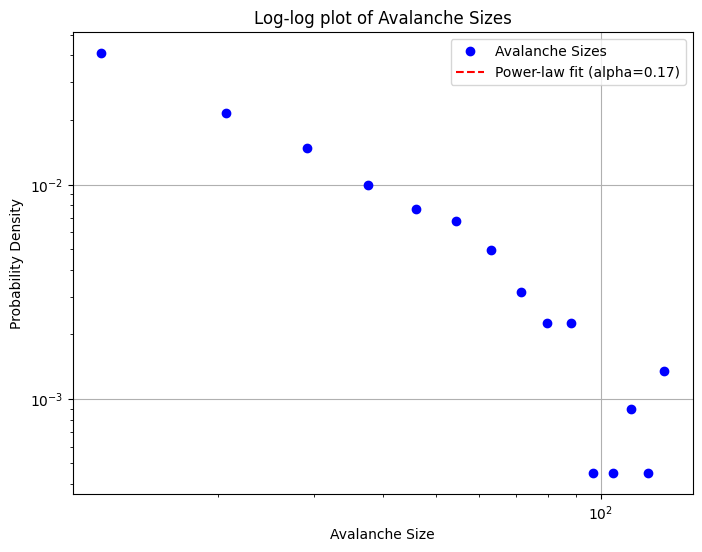

In [112]:
avalanche_sizes = network.compute_avalanche_sizes(spikes_list, 1, 0.075)
plt.figure()
graphics.bin_avalance_durations(avalanche_sizes)

hist, bin_edges = np.histogram(avalanche_sizes, bins='auto', density=True)

# Find the midpoint of each bin for plotting purposes
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, hist, marker='o', linestyle='None', color='b', label='Avalanche Sizes')

# Fit a power-law function to the data (optional)
fit = powerlaw.fit(avalanche_sizes)
alpha = fit[0]  # Extract the fitted exponent

# Plot the power-law fit
plt.loglog(bin_centers, powerlaw.pdf(bin_centers, alpha), color='r', linestyle='--', label=f'Power-law fit (alpha={alpha:.2f})')

plt.xlabel('Avalanche Size')
plt.ylabel('Probability Density')
plt.title('Log-log plot of Avalanche Sizes')
plt.legend()
plt.grid(True)
plt.show()

Just based off of the power-law plot, we see the network under these conditions behaving in a sub-critical manner. Typically, critically-tuned networks have a power law relationship of 1.5 < $\alpha$ < 2.5, so we can clearly see the dynamics as is don't support SOC. Further exploration of the parameter space and tuning of network dynamics is needed to acheive a regime of SOC.

In the above example, we set the target firing rate well above what the neurons could reach given the network parameters, so we see the neurons all grow in size to try and make more connections to reach this firing rate. If we instead set the target firing rate within reach of the neurons, we expect the neuron sizes to shrink in order to keep from going above the target firing rate, yielding a lower mean firing rate.

Simulating:   0%|          | 7/10000 [00:00<02:31, 66.02it/s]

Simulating: 100%|██████████| 10000/10000 [01:51<00:00, 89.49it/s]


mean firing rate: 0.1189299999999811


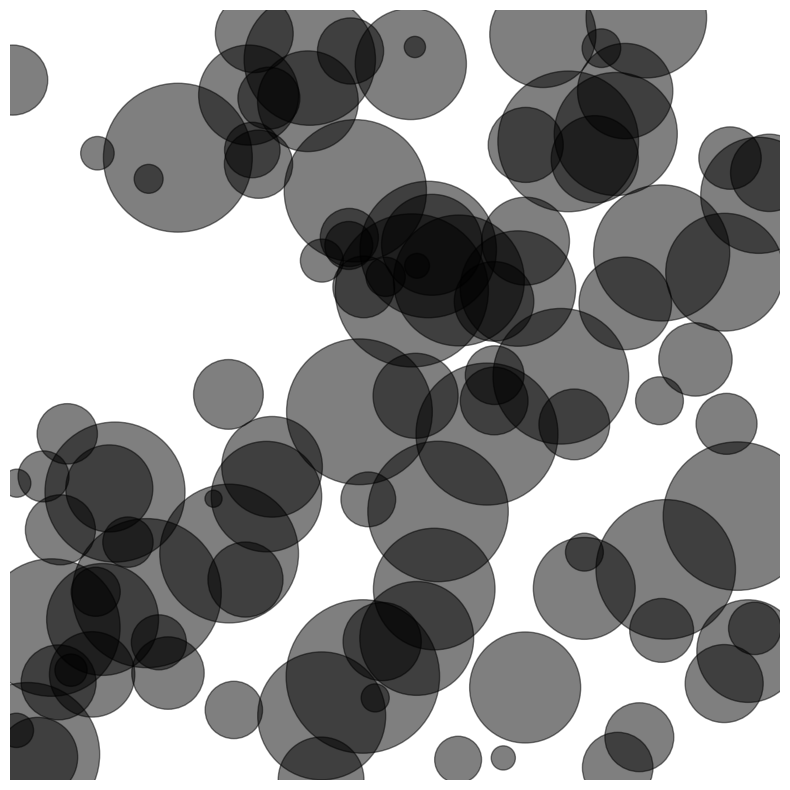

In [118]:
network = Network(N=100, sandbox_size = (1000,1000), tfr = 0.01, size_range=(10,100))
graphics = Graphics()

network.init_neurons()
graphics.draw(network)

network.tfr = 0.1
spikes_list, V_list, firing_rates_list, size_list = network.simulate(duration = 1000, dt = 0.1, spike_input=10, input_noise=0.5, leak=0.01, animate=False)


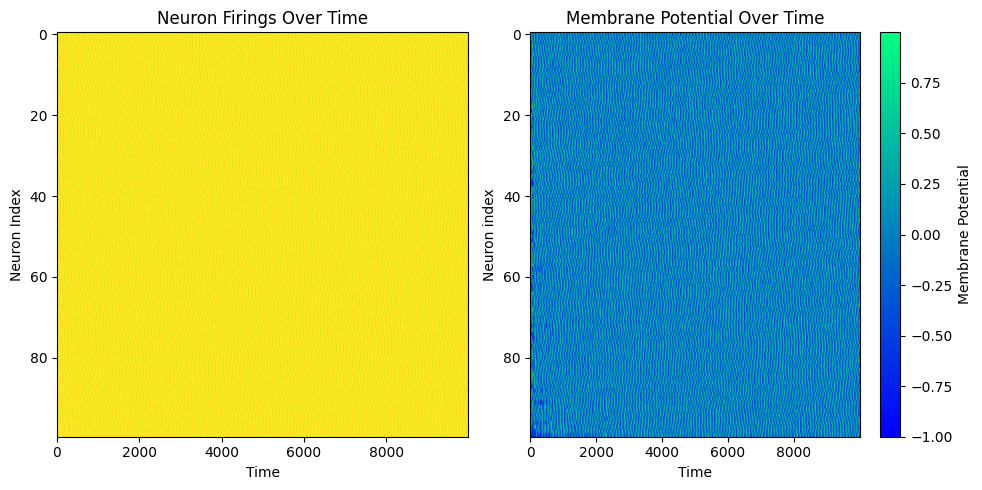

In [119]:
graphics.plot_neuron_activity(spikes_list, V_list)

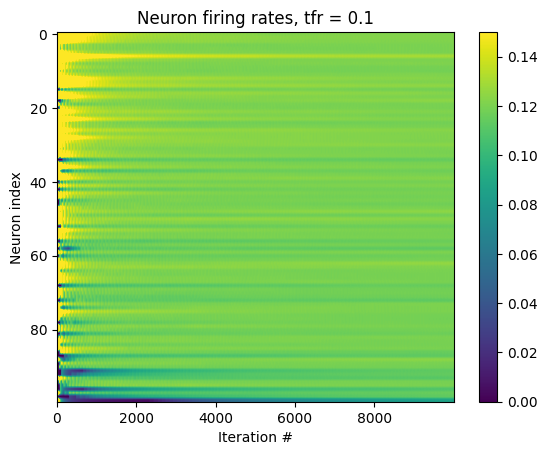

In [120]:
graphics.plot_firing_rates(network, firing_rates_list)

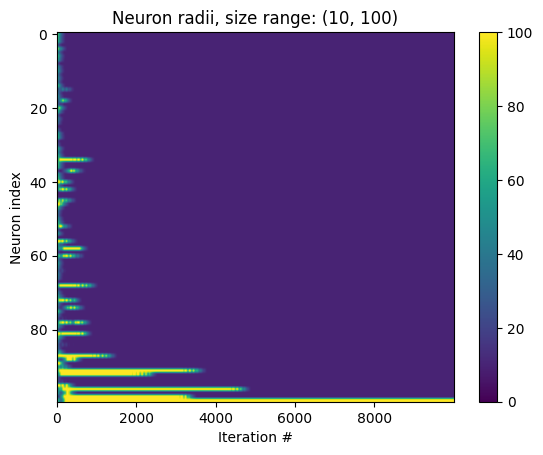

In [121]:
graphics.plot_neuron_sizes(network, size_list)

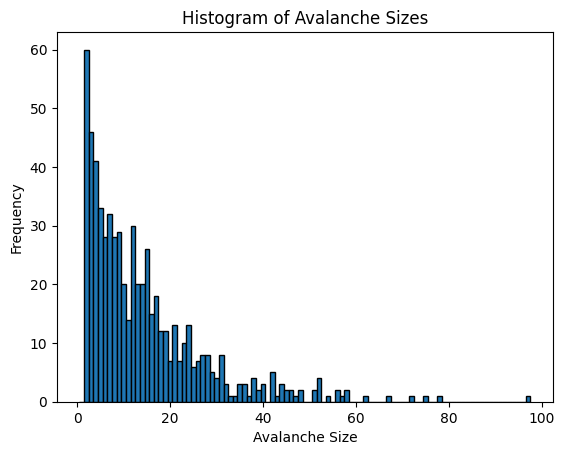

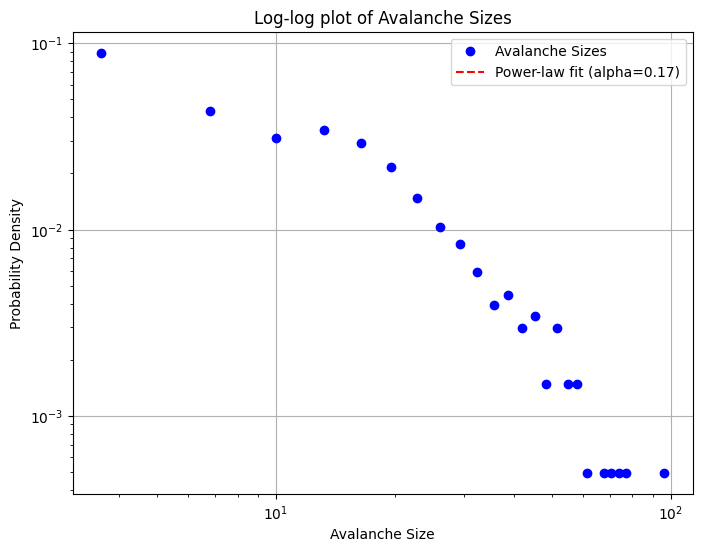

In [127]:
avalanche_sizes = network.compute_avalanche_sizes(spikes_list, 1, 0.01)
plt.figure()
graphics.bin_avalance_durations(avalanche_sizes)

hist, bin_edges = np.histogram(avalanche_sizes, bins='auto', density=True)

# Find the midpoint of each bin for plotting purposes
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, hist, marker='o', linestyle='None', color='b', label='Avalanche Sizes')

# Fit a power-law function to the data (optional)
fit = powerlaw.fit(avalanche_sizes)
alpha = fit[0]  # Extract the fitted exponent

# Plot the power-law fit
plt.loglog(bin_centers, powerlaw.pdf(bin_centers, alpha), color='r', linestyle='--', label=f'Power-law fit (alpha={alpha:.2f})')

plt.xlabel('Avalanche Size')
plt.ylabel('Probability Density')
plt.title('Log-log plot of Avalanche Sizes')
plt.legend()
plt.grid(True)
plt.show()

Unfortunately, after running these simulations I've discovered a bug with how the connectivity matrix M is being updated, which only became apparent once I'd optimized my code to be able to simulate evolution over long durations for larger networks. I hope to have this fixed within a day. However, The dynamics and evolution of the network still appear functioning despite the evolution deviates from the proposed model

One major deviation from the Kossio paper is in the growth of the dendrite arbor. Due to time/computational constraints, my current neuron radii are clamped between 1/100th and 1/10th the sandbox side-length, with a linear increase/decrease, to prevent overgrowth when $f_{target}$ >> $f_{neuron}$. In the Kassio paper, arbor radii grow faster the farther away a neuron's firing rate is from the target firing rate, and vice-versa. The radii also all approach the same size. This is the next feature I hope to implement, giving my network more adaptability.

For other measures of criticality, namely avalanche duration, more computational resources would be necessary to reach a simulation duration that could yield several orders of magnitude for avalanche durations. One possible method I intend to pursue is using the Talapas supercomputer here at the University of Oregon, which I'm currently in the process of getting access to. 